In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description

In [2]:
connFilename = '../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)
gmregions_names[index_of_interest]

array([b'ctx-rh-posteriorcingulate', b'ctx-lh-posteriorcingulate'],
      dtype='|S49')

### Prepare matrices for regression

In [3]:
thresh_subjapp = int(np.ceil(nsubject * 0.1)) # consider bundles that appear at least in 30 % of the subjects

region_ftimecourse = load("../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95.pkl")
regions_in_voxels = load('../../atlas_data/fiber_atlas/regions95_voxels.pkl')[:,:,:,1:]

In [4]:
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.array(X)
X_norm = (np.diag(1/X.sum(axis=0)) @ X.T).T

# GENERATING caring about voxel percentage

root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata()[:,:,:,1:], 
                             nib.load(root + atlas_of_interest).affine)

Xp = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundle_coords = tmp[:,[0,1,2]]

        prob_vox = np.zeros_like(prob_regions[:,:,:,0])
        prob_vox[bundle_coords[:,0], bundle_coords[:,1], bundle_coords[:,2]] = 1.0

        region_i = prob_regions[:,:,:,i-1]
        region_j = prob_regions[:,:,:,j-1]

        bundle_proba_i = (region_i * prob_vox)
        bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
        bundle_proba_j = (region_j * prob_vox)
        bproba_j = bundle_proba_j[bundle_proba_j!=0].mean()

        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = bproba_i
        vec[j-1] = bproba_j
        Xp.append(vec)

Xp = np.array(Xp)
Xp = np.nan_to_num(Xp)

 36%|███▌      | 34/95 [02:49<03:45,  3.69s/it]/tmp/ipykernel_582521/337905332.py:46: RuntimeWarning: Mean of empty slice.
  bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
/home/chchan/miniconda3/envs/microstruct_atlas/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 95/95 [05:03<00:00,  3.20s/it]


In [5]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = graph_utils.make_cycle(region_ftimecourse.shape[-1])

Ls = graph_utils.compute_directed_laplacian(bundle_graph)
Lt = graph_utils.compute_directed_laplacian(cycle)
Xmult = np.array([X.T for _ in range(region_ftimecourse.shape[-1])])

### Hyperparameters Optimization I
- Train / Test split: 80% / 20%
    - use direct loss values
    - use FC similarity of train reconstruction and val reconstruction

In [704]:
split_ratio = 0.8
train_size = int(split_ratio * region_ftimecourse.shape[1])
train_timecourse, test_timecourse = region_ftimecourse[:,:train_size], region_ftimecourse[:,train_size:]

In [705]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle1 = graph_utils.make_cycle(train_size)
cycle2 = graph_utils.make_cycle(region_ftimecourse.shape[-1] - train_size)

Ls = graph_utils.compute_directed_laplacian(bundle_graph)
Lt_train = graph_utils.compute_directed_laplacian(cycle1)
Lt_test = graph_utils.compute_directed_laplacian(cycle2)

In [714]:
# g1 is spatial hyperparam and g2 is temporal hyperparam
grid1d = np.sort(np.concatenate([np.logspace(-3,3,7), 5 * np.logspace(-3,1,4)]))
hyperparam_grid = np.array([(g1,g2) for g1 in grid1d for g2 in grid1d])

In [718]:
nbepoch = 100
Xtorch_train = torch.Tensor(np.array([X.T for _ in range(train_size)]))
Xtorch_test = torch.Tensor(np.array([X.T for _ in range(region_ftimecourse.shape[-1] - train_size)]))

infos = {'bundle_train': [], 'bundle_test': [], 'logs_train':[] , 'logs_test': []}
for (g1,g2) in tqdm(hyperparam_grid):
    # TRAIN
    ywhite_init = np.random.random((train_size, X.shape[0])) - 0.5
    ytorch = torch.Tensor(train_timecourse.T)
    whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt_train)

    bundle_opt_train, logs_train = inpaint_utils.optimize_lreg(whitetorch, Xtorch_train, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                    verbose=False, num_epochs=nbepoch, logging=True, p1=g1, p2=g2, lr=1)

    # TEST
    ywhite_init = np.random.random((region_ftimecourse.shape[-1] - train_size, X.shape[0])) - 0.5
    ytorch = torch.Tensor(test_timecourse.T)
    whitetorch = torch.Tensor(ywhite_init).requires_grad_(True) ; Lstorch = torch.Tensor(Ls) ; Lttorch = torch.Tensor(Lt_test)

    bundle_opt_test, logs_test = inpaint_utils.optimize_lreg(whitetorch, Xtorch_test, ytorch, Ls=Lstorch, Lt=Lttorch, 
                                    verbose=False, num_epochs=nbepoch, logging=True, p1=g1, p2=g2, lr=1)
    
    infos['bundle_train'].append(bundle_opt_train)
    infos['bundle_test'].append(bundle_opt_test)
    infos['logs_train'].append(logs_train)
    infos['logs_test'].append(logs_test)

100%|██████████| 121/121 [5:49:21<00:00, 173.23s/it]  


In [759]:
# scalenorm = np.abs(region_ftimecourse).mean()
meandeg = bundle_graph.sum(axis=0).astype(float).mean()

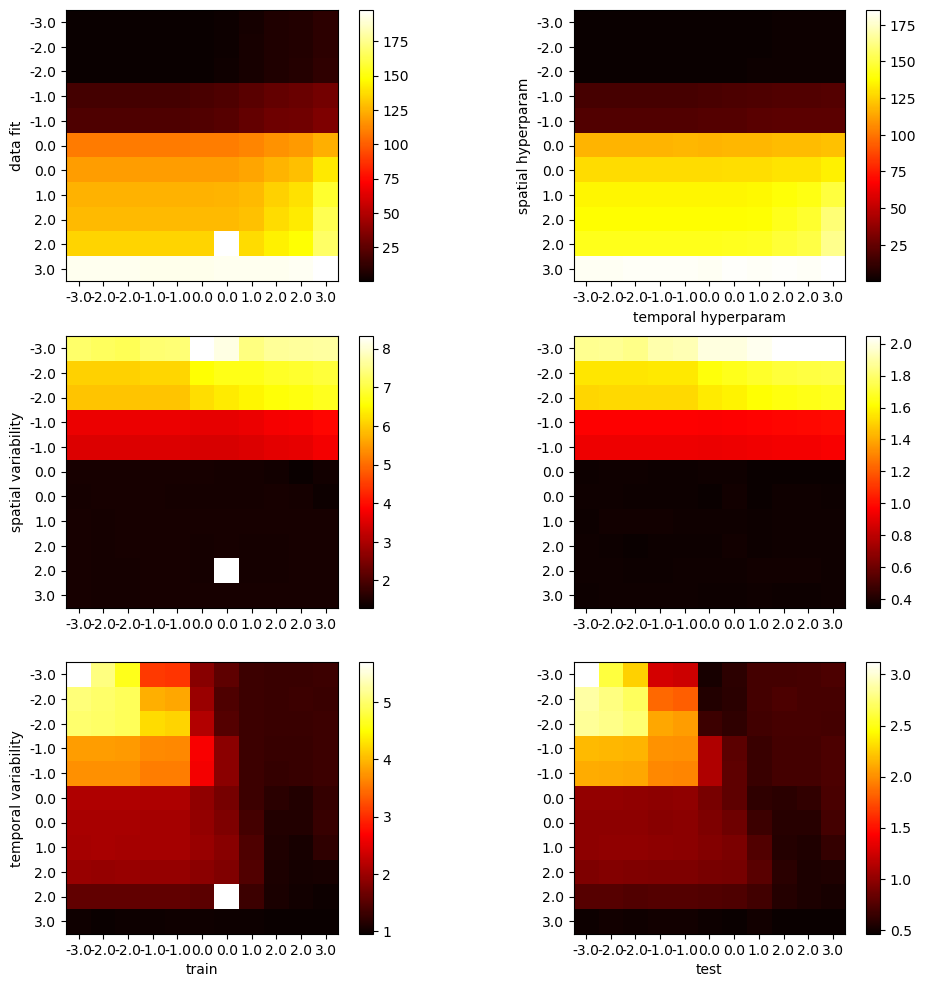

In [959]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
logtype = ['logs_train', 'logs_test'] ; losstype = ['gen_loss', 'spatial_reg_loss', 'temporal_reg_loss']
scalinglog = [train_size, region_ftimecourse.shape[-1] - train_size]
scalingloss = [1, (bundle_opt.shape[0] * meandeg), 1]

for j in range(len(losstype)):
    for k in range(len(logtype)):
        if losstype[j]=='spatial_reg_loss':
            im = ax[j,k].imshow(np.array([infos[logtype[k]][d][losstype[j]][-1]
                                      for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[j], cmap='hot')
        else:
            im = ax[j,k].imshow(np.array([infos[logtype[k]][d][losstype[j]][-1]
                                      for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[j] / scalinglog[k], cmap='hot')
        

        if j == 0 and k == 1:
            ax[j,k].set_ylabel('spatial hyperparam')
            ax[j,k].set_xlabel('temporal hyperparam')
        
        if j == 2 and k == 0: ax[j,k].set_xlabel('train')
        if j == 2 and k == 1: ax[j,k].set_xlabel('test')

        if j == 0 and k == 0: ax[j,k].set_ylabel('data fit')
        if j == 1 and k == 0: ax[j,k].set_ylabel('spatial variability')
        if j == 2 and k == 0: ax[j,k].set_ylabel('temporal variability')

        ax[j,k].set_xticks(np.arange(len(grid1d)))
        ax[j,k].set_xticklabels(np.round(np.log10(grid1d)))
        ax[j,k].set_yticks(np.arange(len(grid1d)))
        ax[j,k].set_yticklabels(np.round(np.log10(grid1d)))

        plt.colorbar(im, ax=ax[j, k])

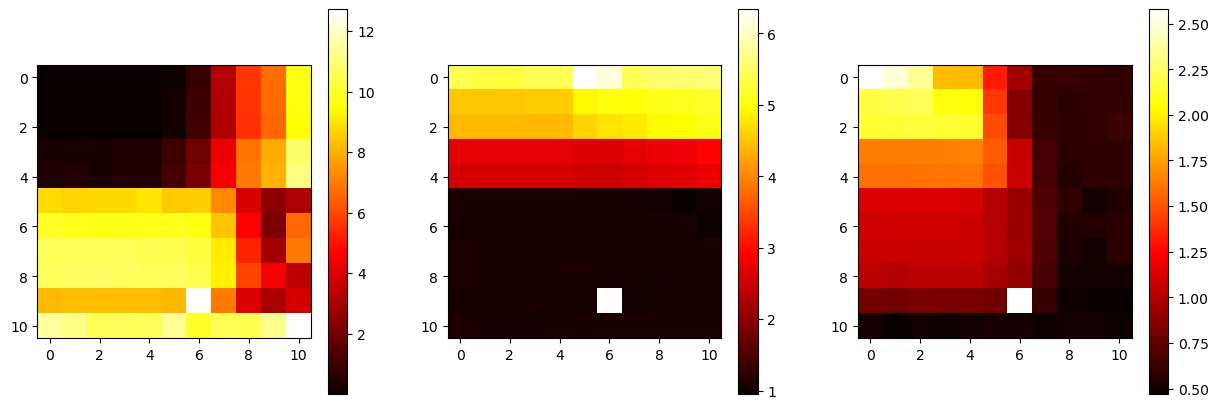

In [770]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
diffs = []
for k in range(3):
    if k == 1:
        tmp1 = np.array([infos[logtype[0]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[k]
        tmp2 = np.array([infos[logtype[1]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalingloss[k]
    else:
        tmp1 = np.array([infos[logtype[0]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalinglog[0] / scalingloss[k]
        tmp2 = np.array([infos[logtype[1]][d][losstype[k]][-1] for d in range(len(hyperparam_grid))]).reshape(11,11) / scalinglog[1] / scalingloss[k]
    
    cur_diff = np.abs(tmp1 - tmp2)
    im = ax[k].imshow(cur_diff, cmap='hot')
    plt.colorbar(im, ax=ax[k])

    diffs.append(cur_diff)

FC Comparison

In [932]:
def FC(a):
    correlation_measure = ConnectivityMeasure(kind='correlation', standardize=False)
    ret = correlation_measure.fit_transform(a.T[None])
    return ret[0]

fc_train_gm = FC(train_timecourse)
fc_test_gm = FC(test_timecourse)

# from scipy.optimize import curve_fit

# def objective(x, a, b):
# 	return a * x + b

# popt, _ = curve_fit(objective, fc_test_gm.flatten(), fc_train_gm.flatten())

# plt.scatter(fc_test_gm.flatten(), fc_train_gm.flatten())
# plt.plot(np.linspace(-0.4,1,1000), objective(np.linspace(-0.4,1,1000), popt[0], popt[1]), color='r')

# np.abs(objective(fc_test_gm, popt[0], popt[1]) - fc_train_gm)

In [933]:
fc_diffs = []
nb_bins_fc = []
for thresh in np.linspace(0,1, 101):
    nb_bins = (np.abs(fc_train_gm) > thresh).astype(float).sum()
    if nb_bins == 0:
        fc_diffs.append(1)
    else:
        tmptrain = (np.abs(fc_train_gm) > thresh).astype(float) * fc_train_gm
        tmptest = (np.abs(fc_test_gm) > thresh).astype(float) * fc_test_gm
        fc_diffs.append(pearsonr(tmptrain.flatten(), tmptest.flatten())[0])
    nb_bins_fc.append(nb_bins)

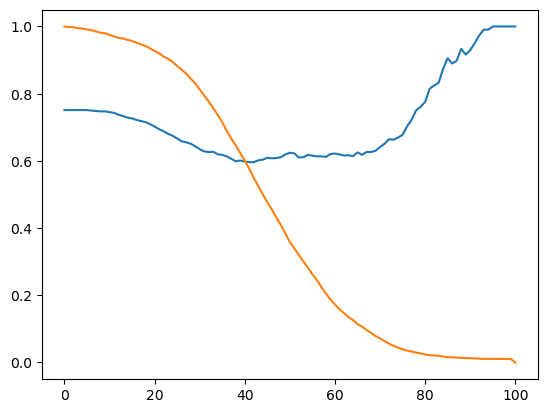

In [934]:
plt.plot(fc_diffs)
plt.plot(nb_bins_fc / np.prod(fc_train_gm.shape))

In [935]:
fc_bundles_diff = []
for nidx in tqdm(range(len(infos['bundle_train']))):
    if np.isnan(infos['bundle_train'][nidx]).sum() > 0 or np.isnan(infos['bundle_test'][nidx]).sum() > 0:
        fc_bundles_diff.append(np.nan)
        continue

    fc_train_bundle = FC(infos['bundle_train'][nidx].T)
    fc_test_bundle = FC(infos['bundle_test'][nidx].T)

    # nb_bins = (np.abs(fc_train_bundle) > 0.5).astype(float).sum()
    # tmptrain = (np.abs(fc_train_bundle) > 0.5).astype(float) * fc_train_bundle
    # tmptest = (np.abs(fc_test_bundle) > 0.5).astype(float) * fc_test_bundle

    tmptrain = (np.abs(fc_train_bundle) > 0).astype(float) * fc_train_bundle
    tmptest = (np.abs(fc_test_bundle) > 0).astype(float) * fc_test_bundle

    fc_bundles_diff.append(pearsonr(tmptrain.flatten(), tmptest.flatten())[0])

100%|██████████| 121/121 [00:57<00:00,  2.09it/s]


In [936]:
np.unravel_index(np.argsort(np.nan_to_num(fc_bundles_diff))[-5:], (grid1d.shape[0],grid1d.shape[0]))

(array([1, 1, 1, 5, 5]), array([1, 0, 2, 4, 2]))

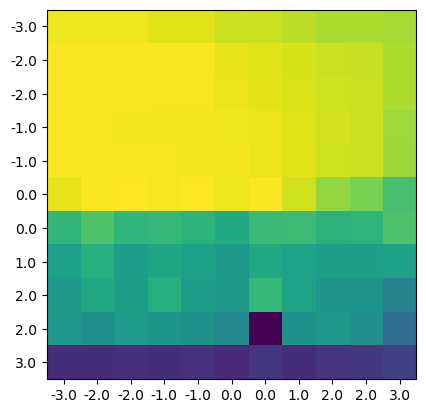

In [955]:
fig, ax = plt.subplots()
ax.imshow(np.nan_to_num(fc_bundles_diff).reshape(grid1d.shape[0],grid1d.shape[0]))
ax.set_xticks(np.arange(len(grid1d)))
ax.set_xticklabels(np.round(np.log10(grid1d)))
ax.set_yticks(np.arange(len(grid1d)))
ax.set_yticklabels(np.round(np.log10(grid1d)))
plt.show()

### Hyperparameter Optimization II

In [7]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]
tmp = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = tmp.shape[:3]
rest_affine = tmp.affine
fmri_coords = load('../resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))))

In [8]:
Xmult = np.array([Xp.T for _ in range(region_ftimecourse.shape[-1])])

bundle_opt, logs = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)

  0%|          | 0/200 [00:00<?, ?it/s]/home/chchan/miniconda3/envs/microstruct_atlas/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 200/200 [01:05<00:00,  3.06it/s]

Losses are decomposed into:
generic loss=tensor([1.8552])
spatialloss=tensor([2965809.2500])
temporalloss=tensor([14861.0010])
sumloss=tensor([1.8552])


In [16]:
importlib.reload(inpaint_utils)
wm_inpainted_lreg_check, mat_check = inpaint_utils.interpolate_activity_old(fmri_coords[:1], bundles_labels[:1], bundle_opt[0], 
                                                                    vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_lreg, mat = inpaint_utils.interpolate_activity(fmri_coords[:1], bundles_labels[:1], bundle_opt[0], 
                                                          vdim, wmmask=wm_mask_subj, normalizing=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 816.97it/s]


In [36]:
# unq, count = np.unique(fmri_coords[0][:,:3], axis=0, return_counts=True)
# unq[count > 1]

In [37]:
tmparray_gm = []
for tidx in tqdm(range(bundle_opt.shape[0])):
    frame0 = zscore(region_ftimecourse[:,tidx])/3
    gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] for k in range(nb_regions)], axis=0)
    gm_activity_voxels[gm_activity_voxels==0] = -100
    tmparray_gm.append(gm_activity_voxels)
tmparray_gm = np.array(tmparray_gm)

 62%|██████▏   | 283/460 [02:21<01:28,  2.00it/s]


KeyboardInterrupt: 

#### Sanity check

In [37]:
tmparray_lreg = []
for k in tqdm(range(bundle_opt.shape[0]-260)):
    tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], 
                                                                       vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
    tmparray_lreg.append(tmp_inpainted)
tmparray_lreg = np.array(tmparray_lreg)

100%|██████████| 200/200 [2:43:05<00:00, 48.93s/it]   


In [40]:
similarity_space = np.zeros((tmparray_gm.shape[1:]))
for x in range(similarity_space.shape[0]):
    for y in range(similarity_space.shape[1]):
        for z in range(similarity_space.shape[2]):
            similarity_space[x,y,z] = utils.pearsonr(tmparray_gm[:200][:,x,y,z], tmparray_lreg[:, x,y,z])[0]
    
similarity_space = np.nan_to_num(similarity_space)
similarity_space[similarity_space==0] = -100

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


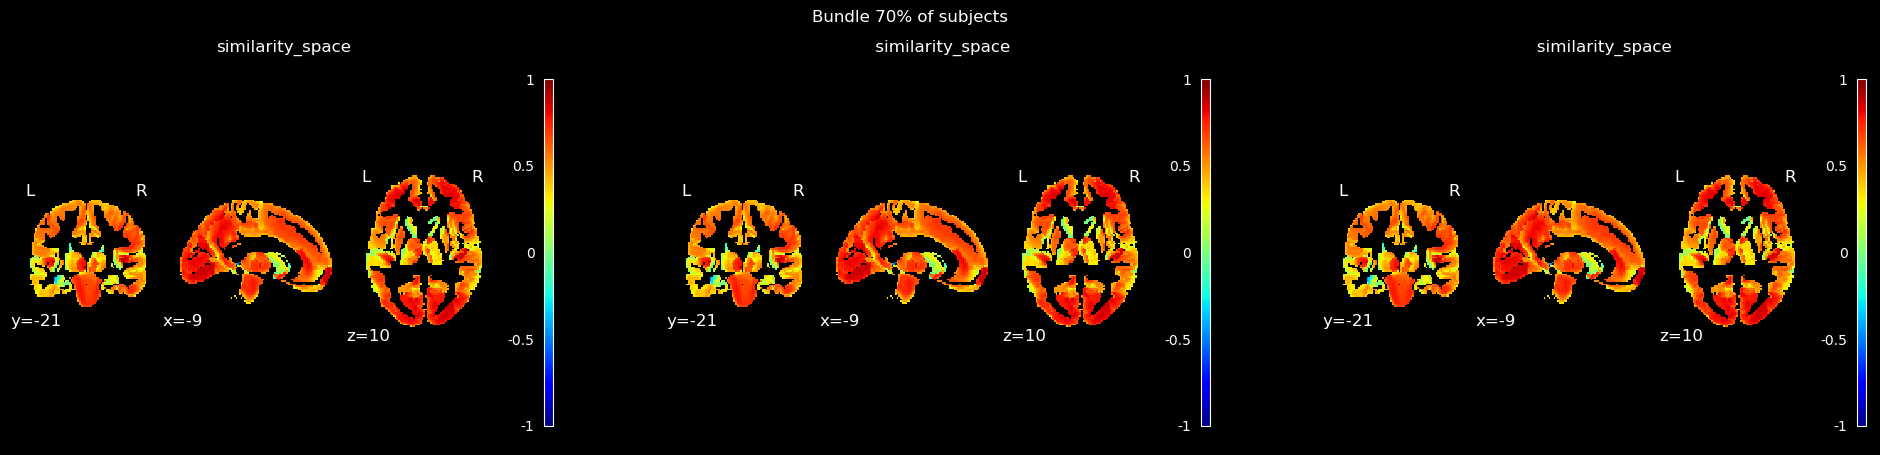

In [41]:
inpaint_mods = [similarity_space, similarity_space, similarity_space]
all_inpaints_names = f'similarity_space, similarity_space,   similarity_space'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

#### Optimization

In [27]:
# g1 is spatial hyperparam and g2 is temporal hyperparam
# grid1d = np.sort(np.concatenate([np.logspace(-3,3,7), 5 * np.logspace(-3,1,4)]))
grid1d = np.logspace(-3,3,4)
hyperparam_grid = np.array([(g1,g2) for g1 in grid1d for g2 in grid1d])

In [30]:
bundle_opt_sets, logs_sets = [], []
for (g1,g2) in tqdm(hyperparam_grid):
    bundle_opt, logs = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=False, num_epochs=100, logging=True, p1=g1, p2=g2, lr=1)
    bundle_opt_sets.append(bundle_opt)
    logs_sets.append(logs)

  4%|▍         | 1/25 [03:17<1:19:00, 197.51s/it]


KeyboardInterrupt: 

In [82]:
tmparray_lreg = []
for k in tqdm(range(bundle_opt.shape[0])):
    tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], 
                                                                       vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
    tmparray_lreg.append(tmp_inpainted)
tmparray_lreg = np.array(tmparray_lreg)

100%|██████████| 460/460 [5:33:58<00:00, 43.56s/it]    


In [97]:
similarity_space = np.zeros((tmparray_gm.shape[1:]))
for x in range(similarity_space.shape[0]):
    for y in range(similarity_space.shape[1]):
        for z in range(similarity_space.shape[2]):
            similarity_space[x,y,z] = utils.pearsonr(tmparray_gm[:,x,y,z], tmparray_lreg[:, x,y,z])[0]
    
similarity_space = np.nan_to_num(similarity_space)
similarity_space[similarity_space==0] = -100

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


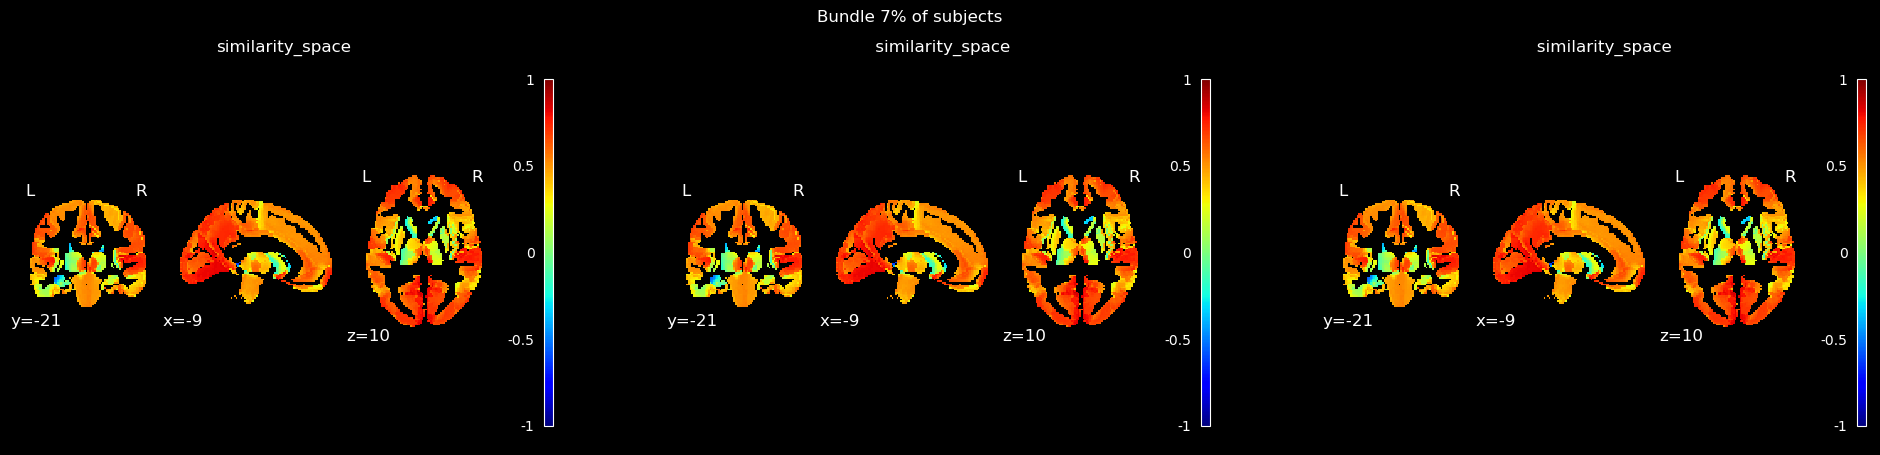

In [106]:
inpaint_mods = [similarity_space, similarity_space, similarity_space]
all_inpaints_names = f'similarity_space, similarity_space,   similarity_space'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

In [ ]:
# NOTE: Close the opened h5 file
hf.close()